## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Mollusca - Zo </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)
    * [5.1. Custom Sequential](#customseq)
    * [5.2. MobileNetV2](#MobileNetV2)
    * [5.3. EfficientNetB0](#EfficientNetB0)
    * [5.4. InceptionV3](#InceptionV3)
* [6. Hyperparameter Tuning](#hptuning)
    * [6.1. Hyperparameter Tuning for MobileNetV2](#hptMobileNetV2)
* [7. Test the Models](#test)
    * [7.1. Test MobileNetV2](#testMobileNetV2)

# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Mollusca** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [38]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Libraries for image processing
from glob import glob
from PIL import Image

# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Mollusca Phylum.

In [2]:
# Load the DataFrame from the CSV file
mollusca_train = pd.read_csv("train_test_splits/Mollusca_train.csv")
mollusca_train.head(3)

eol_content_id  eol_page_id   kingdom    phylum     family  \
0        30003937     46473744  animalia  mollusca  cardiidae   
1         2744855       449459  animalia  mollusca  unionidae   
2        12835846     46454284  animalia  mollusca    conidae   

                                           file_path  
0  mollusca_cardiidae/30003937_46473744_eol-full-...  
1  mollusca_unionidae/2744855_449459_eol-full-siz...  
2  mollusca_conidae/12835846_46454284_eol-full-si...

In [3]:
# Load the DataFrame from the CSV file
mollusca_test = pd.read_csv("train_test_splits/Mollusca_test.csv")
mollusca_test.head(3)

eol_content_id  eol_page_id   kingdom    phylum      family  \
0        22271558     46454284  animalia  mollusca     conidae   
1        12800653      4792502  animalia  mollusca  haliotidae   
2        13998439     46473744  animalia  mollusca   cardiidae   

                                           file_path  
0  mollusca_conidae/22271558_46454284_eol-full-si...  
1  mollusca_haliotidae/12800653_4792502_eol-full-...  
2  mollusca_cardiidae/13998439_46473744_eol-full-...

In [4]:
mollusca_train.shape, mollusca_test.shape

((159, 6), (40, 6))

Number of training examples per family in Mollusca phylum:

In [5]:
mollusca_train['family'].value_counts()

family
cardiidae     48
unionidae     39
conidae       24
haliotidae    24
zonitidae     24
Name: count, dtype: int64

Number of test examples per family:

In [6]:
mollusca_test['family'].value_counts()

family
cardiidae     12
unionidae     10
conidae        6
haliotidae     6
zonitidae      6
Name: count, dtype: int64

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

In [7]:
# Directory where the images are stored
image_root_dir = os.path.join("rare_species")

# Prepend full image path to each file_path
mollusca_train['filepath'] = mollusca_train['file_path'].apply(lambda x: os.path.join(image_root_dir, x))
mollusca_test['filepath'] = mollusca_test['file_path'].apply(lambda x: os.path.join(image_root_dir, x))

# Data generator for TRAINING images (includes augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,            # Normalize pixel values from [0, 255] → [0, 1]
    rotation_range=15,         # Randomly rotate images by up to 15 degrees (can try 30 next time)
    zoom_range=0.1,            # Random zoom inside image (10%) (can try 0.2 next time)
    horizontal_flip=True,      # Randomly flip images horizontally (like mirror view)
    validation_split=0.2       # Reserve 20% of training data for validation (done via 'subset' below)
)

# Data generator for TEST images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Function to create generators based on image size and batch size
def create_generators(image_size=(128, 128), batch_size=16):
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=mollusca_train,         # DataFrame with image filepaths and labels
            x_col='filepath',                 # Column with full path to images
            y_col='family',                   # Column with class labels (family)
            target_size=image_size,           # Resize all images to this size
            class_mode='categorical',         # One-hot encode class labels
            batch_size=batch_size,            # Load this many images per batch
            subset='training',                # Use the training subset (80%)
            shuffle=True,                     # Shuffle the data for training
            seed=4                            # For reproducibility
    )

    val_generator = train_datagen.flow_from_dataframe(
            dataframe=mollusca_train,         # DataFrame with image filepaths and labels
            x_col='filepath',                 # Column with full path to images
            y_col='family',                   # Column with class labels (family)
            target_size=image_size,           # Resize all images to this size
            class_mode='categorical',         # One-hot encode class labels
            batch_size=batch_size,            # Load this many images per batch
            subset='validation',              # Use the training subset (80%)
            shuffle=True,                     # Shuffle the data for training
            seed=4                            # For reproducibility
    )

    test_generator = test_datagen.flow_from_dataframe(
            dataframe=mollusca_test,
            x_col='filepath',
            y_col='family',
            target_size=image_size,
            class_mode='categorical',
            batch_size=1,                     # Load one image at a time for testing
            shuffle=False                     # Do not shuffle so predictions align with input order
    )

    return train_generator, val_generator, test_generator

Side by side comparison of raw images vs preprocessed ones

In [8]:
def visualize_pipeline_processed(df, datagen, image_size=(128, 128), num_samples=5):
    """
    Shows side-by-side comparison of original vs processed (augmented + resized) images.
    
    - df: DataFrame with 'filepath' column
    - datagen: ImageDataGenerator (e.g., train_datagen)
    - image_size: size used in generator (e.g., (128, 128))
    - num_samples: number of samples to visualize
    """
    sample_df = df.sample(n=num_samples, random_state=4).reset_index(drop=True)

    # Preview generator with no labels
    preview_generator = datagen.flow_from_dataframe(
        dataframe=sample_df,
        x_col='filepath',
        y_col=None,
        class_mode=None,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    plt.figure(figsize=(10, num_samples * 2.5))

    for i in range(num_samples):
        # Original image
        original = load_img(sample_df.loc[i, 'filepath'])

        # Processed image (resized, augmented, normalized)
        processed = next(preview_generator)[0]
        processed = np.clip(processed, 0, 1)  # Ensure valid pixel range

        # Plot original
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')

        # Plot processed
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(processed)
        plt.title(f"Processed {image_size[0]}x{image_size[1]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

## 5.1. Custom Sequential <a class="anchor" id="customseq"></a>

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


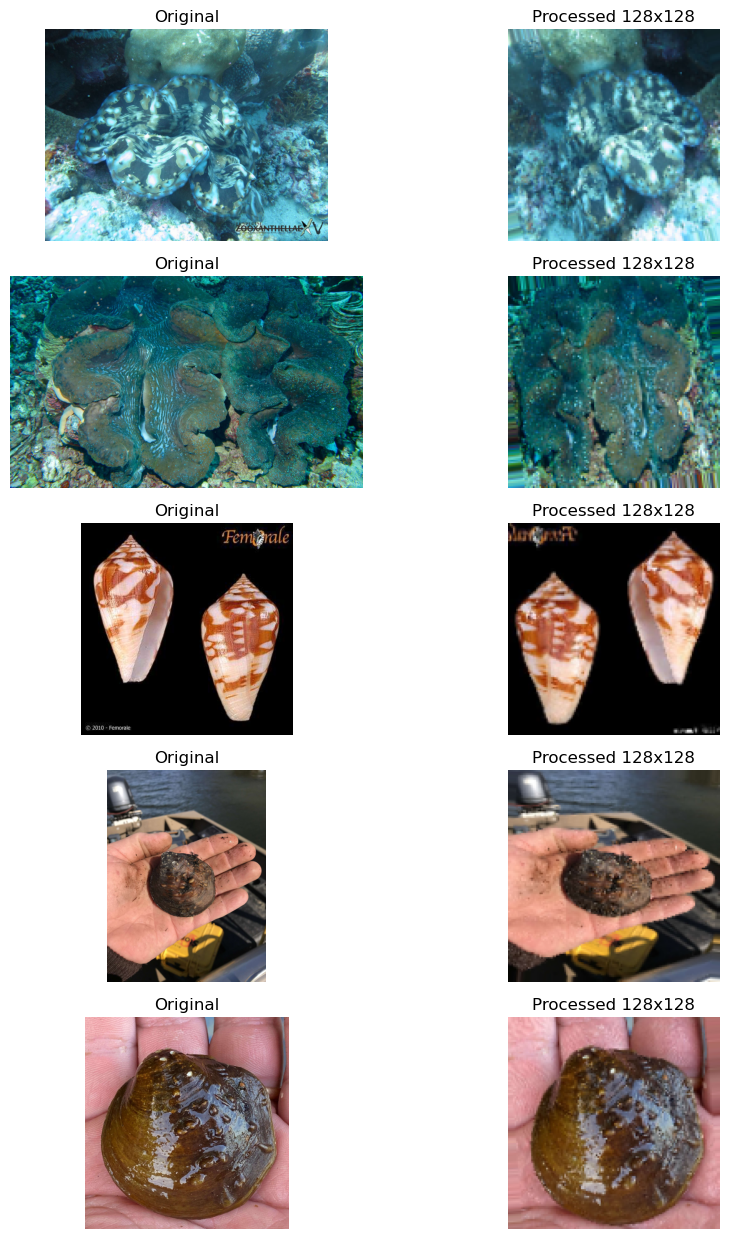

In [9]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(128, 128), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(128, 128), num_samples=5)

In [10]:
model1 = models.Sequential([
    layers.Input(shape=(128, 128, 3)),  # RGB images

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting

    # Output Layer
    layers.Dense(5, activation='softmax')  # 5 classes
])

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,             # Start with 10–15 epochs and adjust later
    class_weight=None      # You can add weights here if needed
)
# Execution time: 6m 25.4s

Epoch 1/30
1/8 [==>...........................] - ETA: 20s - loss: 1.6300 - accuracy: 0.1875

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 13s 1s/step - loss: 1.6245 - accuracy: 0.2734 - val_loss: 1.4315 - val_accuracy: 0.5484
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 1.4521 - accuracy: 0.3672 - val_loss: 1.1000 - val_accuracy: 0.5161
Epoch 3/30
8/8 [==============================] - 11s 1s/step - loss: 1.3110 - accuracy: 0.4922 - val_loss: 0.9065 - val_accuracy: 0.6774
Epoch 4/30
8/8 [==============================] - 11s 1s/step - loss: 1.1310 - accuracy: 0.5938 - val_loss: 0.9315 - val_accuracy: 0.6452
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 1.0493 - accuracy: 0.6016 - val_loss: 0.8473 - val_accuracy: 0.6452
Epoch 6/30
8/8 [==============================] - 12s 1s/step - loss: 0.9508 - accuracy: 0.6250 - val_loss: 0.9321 - val_accuracy: 0.6452
Epoch 7/30
8/8 [==============================] - 12s 1s/step - loss: 0.9472 - accuracy: 0.5859 - val_loss: 0.7388 - val_accuracy: 0.7097
Epoch 8/30
8/8 [==============================]

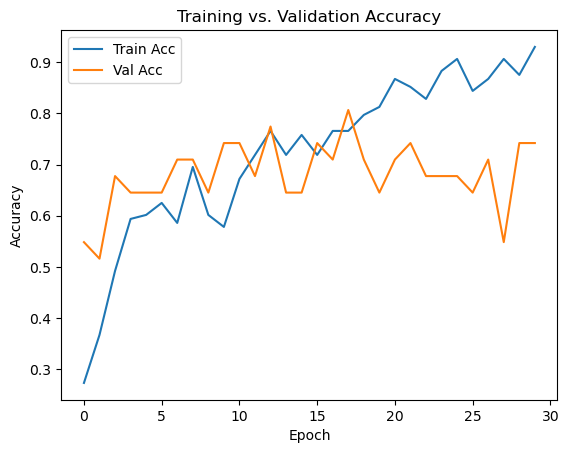

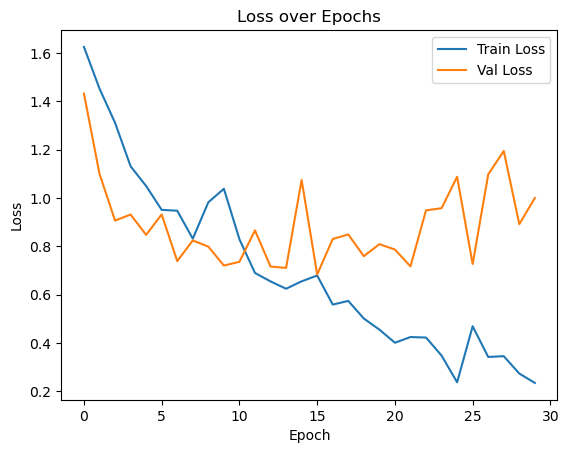

In [12]:
# plot the results
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Loss
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

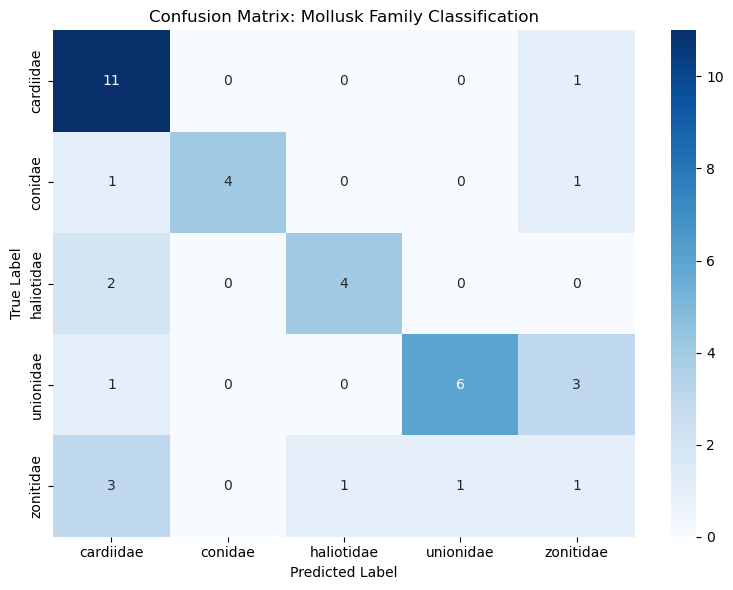

In [13]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model1.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.2. MobileNetV2 <a class="anchor" id="MobileNetV2"></a>

- No need to change the image size since we need 128x128 again. 
- Also, keep batch size of 16.

In [14]:
# Load base model without top layer
base_model = MobileNetV2(
    input_shape=(128, 128, 3),  # Match your resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet-pretrained weights
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

# Build custom model
model2 = models.Sequential([
    base_model,                                # Feature extractor
    layers.GlobalAveragePooling2D(),           # Pool over spatial dimensions
    layers.Dropout(0.3),                       # Regularization layer
    layers.Dense(128, activation='relu'),      # Fully connected layer
    layers.Dense(5, activation='softmax')      # Output layer (5 mollusk families)
])

# Compile model
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary for your viewing pleasure
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 1646

In [ ]:
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,           # Start small, increase if needed
    verbose=1
)
# Execution time: 7m 27.6s

Epoch 1/50
7/8 [=========================>....] - ETA: 1s - loss: 1.8051 - accuracy: 0.3214

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 23s 2s/step - loss: 1.8253 - accuracy: 0.3125 - val_loss: 1.5682 - val_accuracy: 0.3548
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 1.4847 - accuracy: 0.3594 - val_loss: 1.2615 - val_accuracy: 0.5161
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 1.2490 - accuracy: 0.5312 - val_loss: 1.0768 - val_accuracy: 0.7419
Epoch 4/50
8/8 [==============================] - 13s 2s/step - loss: 1.0993 - accuracy: 0.5938 - val_loss: 0.8391 - val_accuracy: 0.7419
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.8905 - accuracy: 0.7188 - val_loss: 0.7374 - val_accuracy: 0.7742
Epoch 6/50
8/8 [==============================] - 9s 1s/step - loss: 0.7929 - accuracy: 0.7578 - val_loss: 0.6955 - val_accuracy: 0.8065
Epoch 7/50
8/8 [==============================] - 10s 1s/step - loss: 0.6887 - accuracy: 0.8047 - val_loss: 0.5414 - val_accuracy: 0.8387
Epoch 8/50
8/8 [==============================

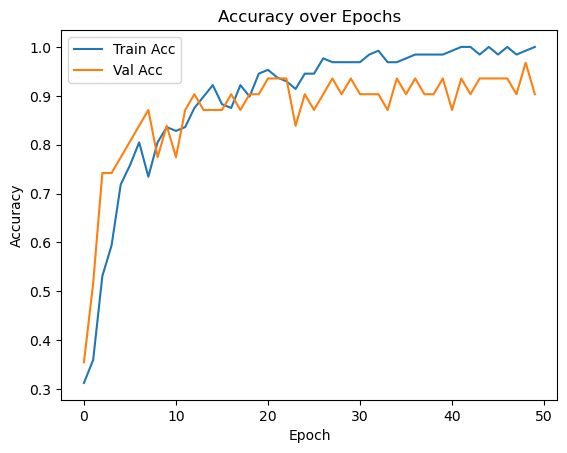

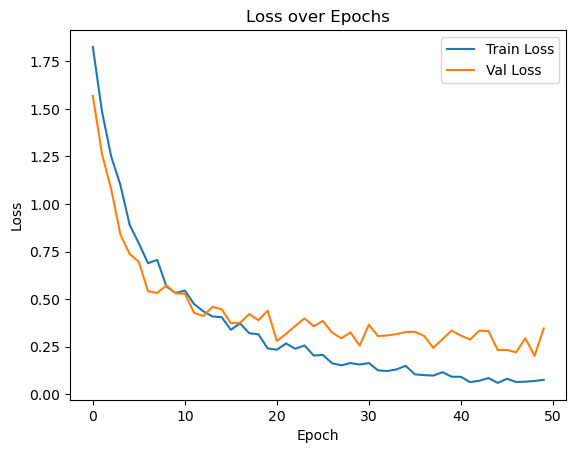

In [16]:
# Accuracy
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

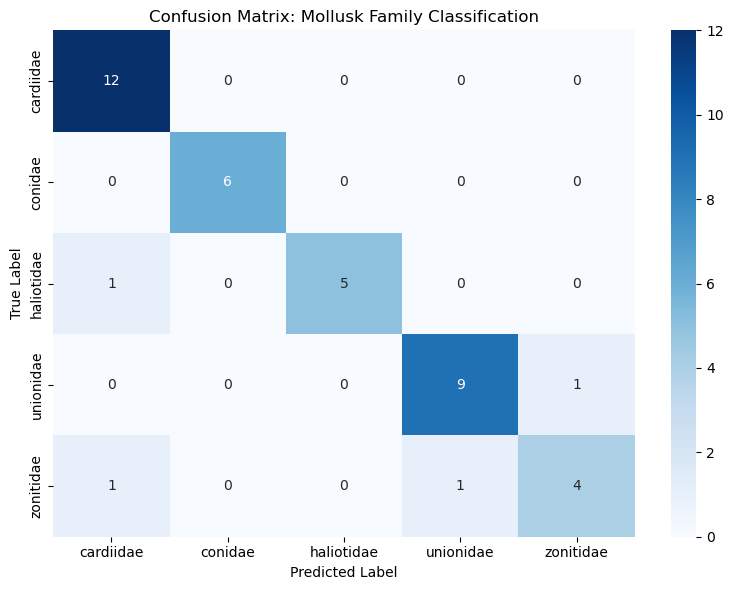

In [17]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model2.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.3. EfficientNetB0 <a class="anchor" id="EfficientNetB0"></a>

Need image size of 224x224

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


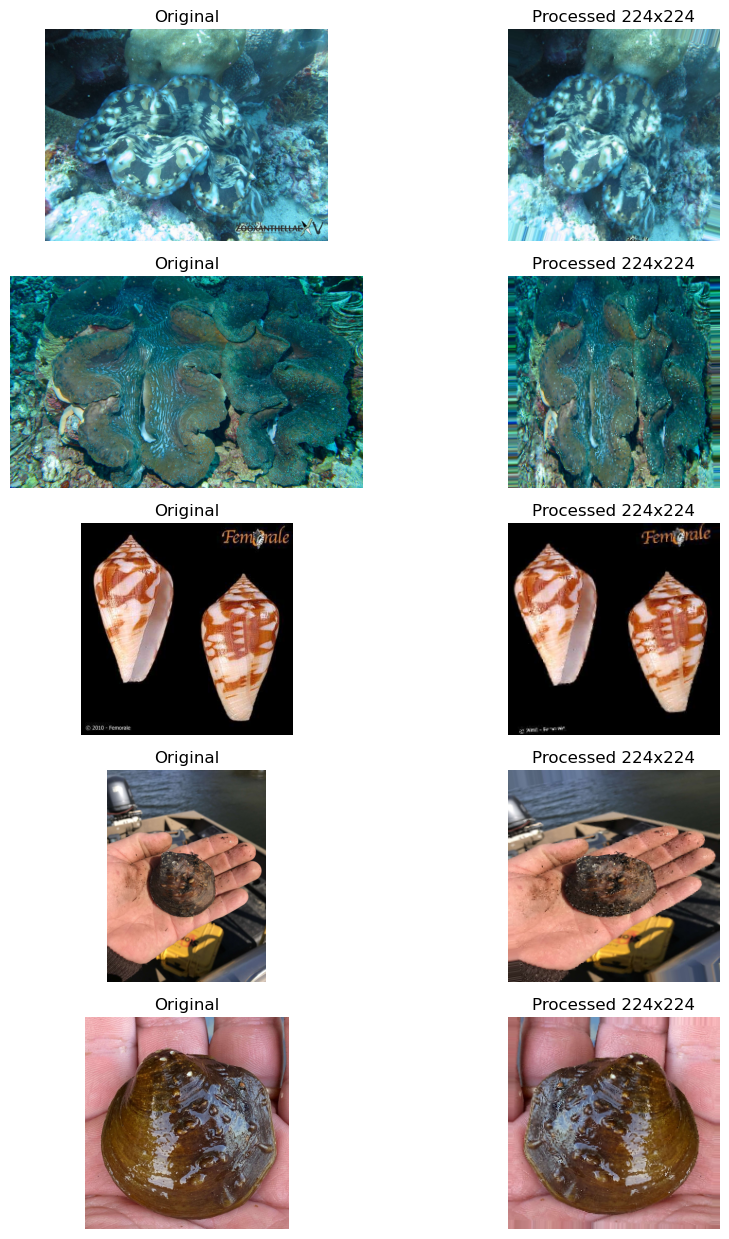

In [18]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(224, 224), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(224, 224), num_samples=5)

In [19]:
# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),   # match EfficientNetB0 default input size
    include_top=False,           # Remove the original classifier head
    weights='imagenet'           # Use pre-trained ImageNet weights
)

# Freeze the base model to use it as a fixed feature extractor
base_model.trainable = False

# Build your custom classifier head
model3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Compile the model
model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 4214184 (16.08 MB)
Trainable params: 164

In [ ]:
history3 = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1
)
# Ececution time: 8m 24.0s

Epoch 1/25
6/8 [=====================>........] - ETA: 3s - loss: 1.6535 - accuracy: 0.2083

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 27s 3s/step - loss: 1.6367 - accuracy: 0.2266 - val_loss: 1.6149 - val_accuracy: 0.2581
Epoch 2/25
8/8 [==============================] - 18s 2s/step - loss: 1.5547 - accuracy: 0.3359 - val_loss: 1.6643 - val_accuracy: 0.2581
Epoch 3/25
8/8 [==============================] - 17s 2s/step - loss: 1.5551 - accuracy: 0.3125 - val_loss: 1.6910 - val_accuracy: 0.2581
Epoch 4/25
8/8 [==============================] - 18s 2s/step - loss: 1.5371 - accuracy: 0.3125 - val_loss: 1.7125 - val_accuracy: 0.2581
Epoch 5/25
8/8 [==============================] - 18s 2s/step - loss: 1.5567 - accuracy: 0.2578 - val_loss: 1.7265 - val_accuracy: 0.2581
Epoch 6/25
8/8 [==============================] - 18s 2s/step - loss: 1.5743 - accuracy: 0.2578 - val_loss: 1.7274 - val_accuracy: 0.2581
Epoch 7/25
8/8 [==============================] - 20s 3s/step - loss: 1.5474 - accuracy: 0.2734 - val_loss: 1.7099 - val_accuracy: 0.2581
Epoch 8/25
8/8 [=============================

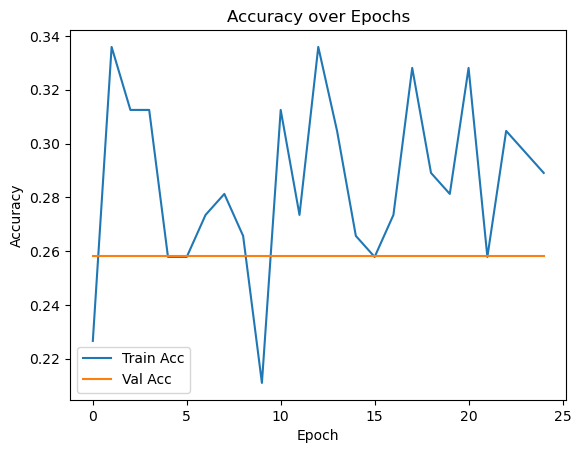

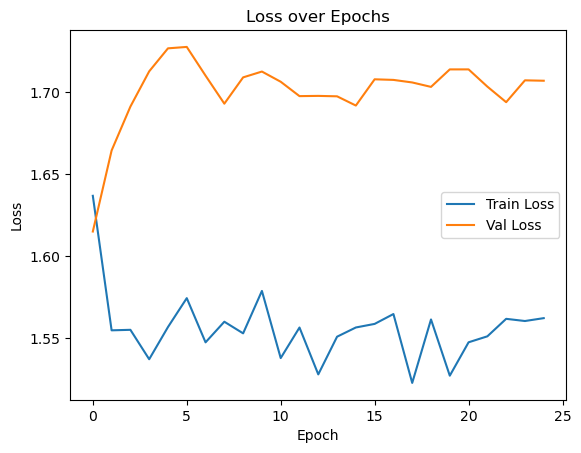

In [21]:
# Accuracy
plt.plot(history3.history['accuracy'], label='Train Acc')
plt.plot(history3.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

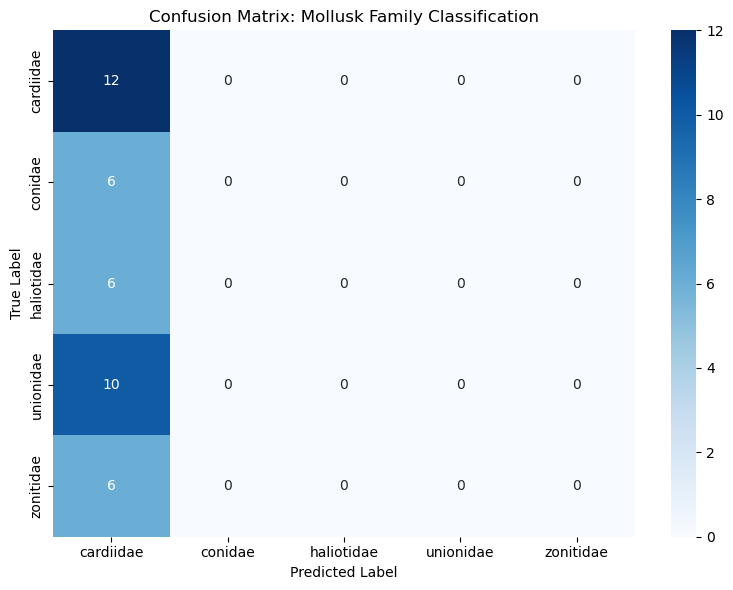

In [22]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model3.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.4. InceptionV3 <a class="anchor" id="InceptionV3"></a>

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


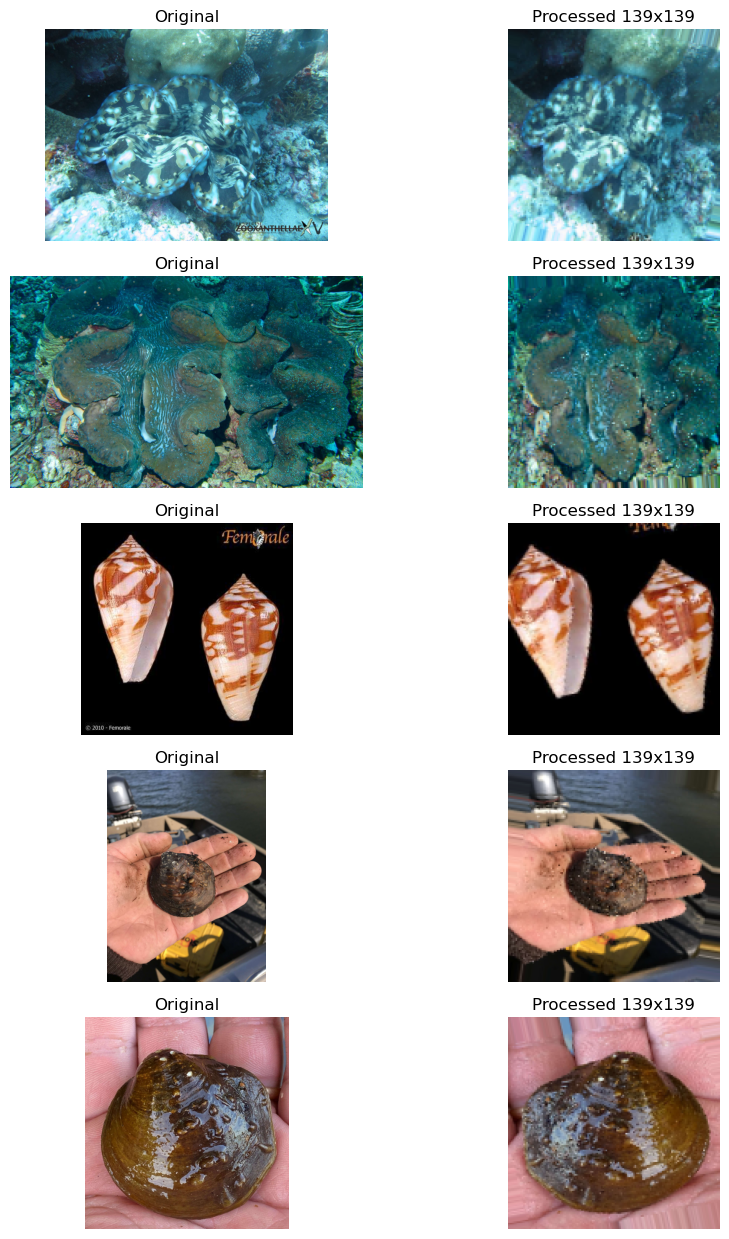

In [23]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(139,139), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(139,139), num_samples=5)

In [24]:
# Load InceptionV3 base model WITHOUT the top classifier
base_model = InceptionV3(
    input_shape=(139, 139, 3),   # Must be at least 139x139
    include_top=False,           # Remove the original classifier
    weights='imagenet'           # Use pretrained ImageNet weights
)

# Unfreeze last 50 layers for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the custom classification head
model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 mollusk families
])

# Compile the model
model4.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model4.summary()

87910968/87910968 [==============================] - 24s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 22065701 (84.17 MB)
Trainable params: 74

In [ ]:
# Train the model
history4 = model4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)
# Execution time: 4m 39.8s

Epoch 1/30


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 23s 2s/step - loss: 1.3873 - accuracy: 0.4375 - val_loss: 2.2080 - val_accuracy: 0.4839
Epoch 2/30
8/8 [==============================] - 14s 2s/step - loss: 0.7312 - accuracy: 0.7969 - val_loss: 1.8136 - val_accuracy: 0.6452
Epoch 3/30
8/8 [==============================] - 13s 2s/step - loss: 0.4019 - accuracy: 0.9141 - val_loss: 1.4588 - val_accuracy: 0.6774
Epoch 4/30
8/8 [==============================] - 13s 2s/step - loss: 0.3251 - accuracy: 0.9219 - val_loss: 1.0636 - val_accuracy: 0.7742
Epoch 5/30
8/8 [==============================] - 13s 2s/step - loss: 0.1789 - accuracy: 0.9531 - val_loss: 1.1140 - val_accuracy: 0.8065
Epoch 6/30
8/8 [==============================] - 15s 2s/step - loss: 0.1332 - accuracy: 0.9766 - val_loss: 0.8813 - val_accuracy: 0.7742
Epoch 7/30
8/8 [==============================] - 14s 2s/step - loss: 0.1001 - accuracy: 0.9766 - val_loss: 1.0306 - val_accuracy: 0.7742
Epoch 8/30
8/8 [=============================

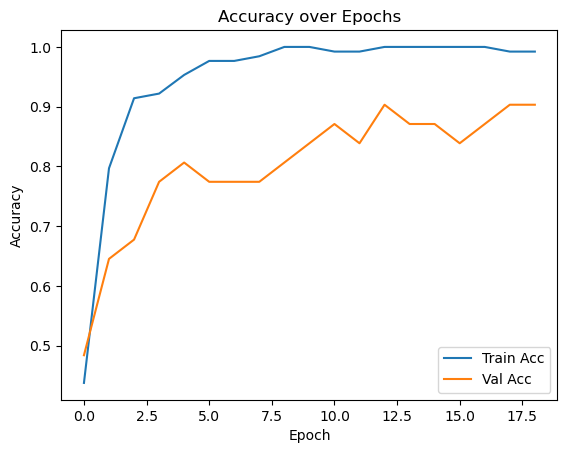

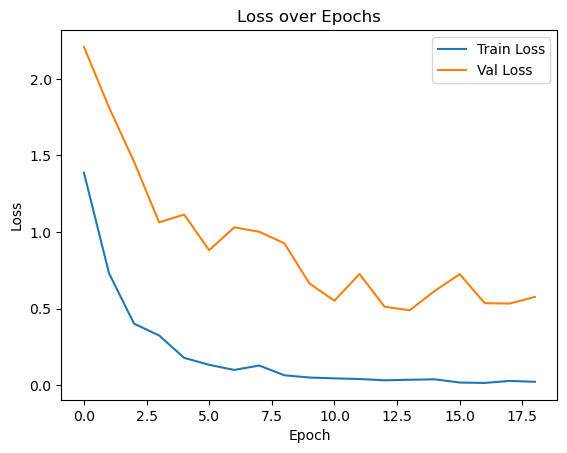

In [26]:
# Accuracy
plt.plot(history4.history['accuracy'], label='Train Acc')
plt.plot(history4.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

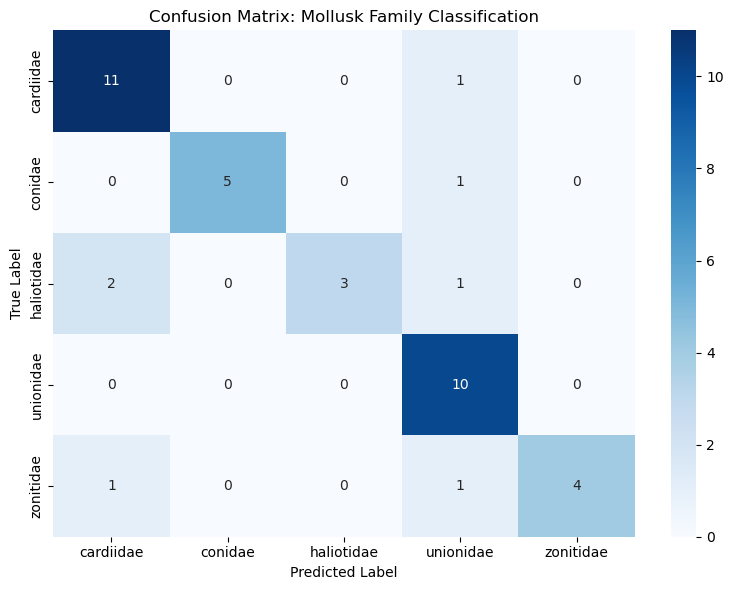

In [27]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model4.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 6. Hyperparameter tuning <a class="anchor" id="hptuning"></a>

## 6.1. Hyperparameter tuning for MobileNetV2<a class="anchor" id="hptMobileNetV2"></a>

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


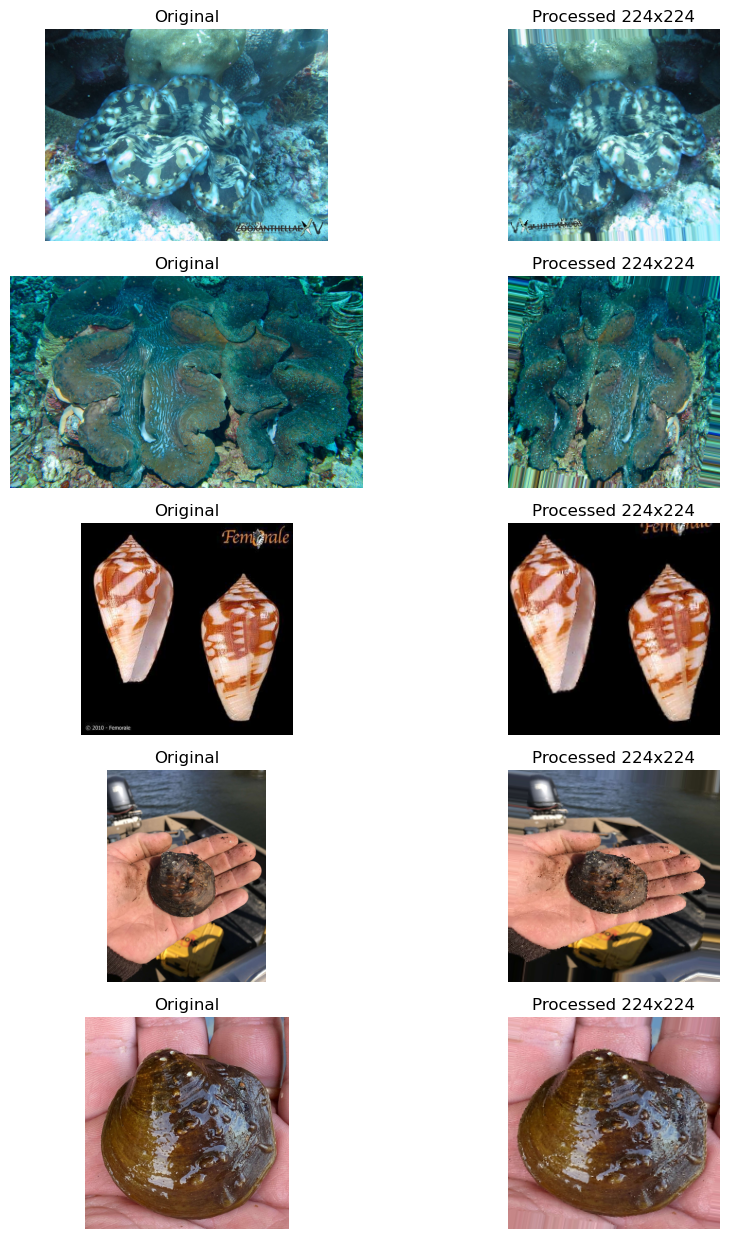

In [28]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(224, 224), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(224, 224), num_samples=5)

In [ ]:
# Define hyperparameter grid
optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]
dropouts = [0.2, 0.3, 0.4, 0.5]
dense_units = [64, 128, 256]
unfreeze_depths = [25, 50, 75]
batch_sizes = [8, 16]
image_sizes = [(128, 128), (224, 224)]  # Test MobileNetV2 with multiple resolutions

# Create all combinations
all_combinations = list(itertools.product(
    optimizers_list, learning_rates, dropouts,
    dense_units, unfreeze_depths, batch_sizes, image_sizes
))

# Shuffle and sample a manageable batch
random.seed(4)
sampled_combos = random.sample(all_combinations, k=100)

results = []

for i, (opt_name, lr, dropout, units, unfreeze, batch_size, image_size) in enumerate(sampled_combos):
    print(f"\n🔥 Combo {i+1}/{len(sampled_combos)}: "
          f"opt={opt_name}, lr={lr}, dropout={dropout}, units={units}, "
          f"unfreeze={unfreeze}, batch_size={batch_size}, image_size={image_size}")

    # Create generators for this batch_size and image_size
    train_generator, val_generator, _ = create_generators(
        image_size=image_size, batch_size=batch_size
    )

    # Load MobileNetV2 with current image_size
    base_model = MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = True

    # Freeze all but the last `unfreeze` layers
    fine_tune_at = len(base_model.layers) - unfreeze
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(units, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])

    # Select optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compile model
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0
    )

    # Record best validation accuracy
    val_acc = max(history.history['val_accuracy'])
    print(f"✅ Best Val Acc: {val_acc:.4f}")

    results.append({
        'optimizer': opt_name,
        'lr': lr,
        'dropout': dropout,
        'units': units,
        'unfreeze': unfreeze,
        'batch_size': batch_size,
        'image_size': image_size,
        'val_acc': val_acc
    })

# Create leaderboard
df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
print("\n🏆 Top Configs:")
print(df_results.head(10))

# Execution time: 345m 1.4s


🔥 Combo 1/100: opt=rmsprop, lr=0.001, dropout=0.3, units=128, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.


Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 2/100: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 3/100: opt=adam, lr=0.0001, dropout=0.3, units=256, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 4/100: opt=rmsprop, lr=1e-05, dropout=0.4, units=128, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 5/100: opt=sgd, lr=0.001, dropout=0.5, units=64, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 6/100: opt=adam, lr=1e-05, dropout=0.2, units=256, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 7/100: opt=adam, lr=0.0001, dropout=0.3, units=64, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 8/100: opt=adam, lr=0.001, dropout=0.5, units=256, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.4839

🔥 Combo 9/100: opt=adam, lr=0.001, dropout=0.3, units=64, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7097

🔥 Combo 10/100: opt=rmsprop, lr=1e-05, dropout=0.4, units=256, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 11/100: opt=sgd, lr=0.0001, dropout=0.5, units=64, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 12/100: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8065

🔥 Combo 13/100: opt=adam, lr=0.001, dropout=0.5, units=128, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 14/100: opt=rmsprop, lr=0.001, dropout=0.2, units=128, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 15/100: opt=sgd, lr=0.0001, dropout=0.3, units=128, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 16/100: opt=sgd, lr=0.0001, dropout=0.4, units=128, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 17/100: opt=rmsprop, lr=1e-05, dropout=0.2, units=128, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 18/100: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 19/100: opt=adam, lr=1e-05, dropout=0.3, units=256, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 20/100: opt=adam, lr=0.0001, dropout=0.4, units=64, unfreeze=25, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 21/100: opt=rmsprop, lr=0.001, dropout=0.4, units=256, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 22/100: opt=rmsprop, lr=0.001, dropout=0.2, units=64, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 23/100: opt=adam, lr=0.001, dropout=0.3, units=128, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7419

🔥 Combo 24/100: opt=rmsprop, lr=0.001, dropout=0.4, units=256, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.6129

🔥 Combo 25/100: opt=rmsprop, lr=0.001, dropout=0.5, units=128, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.5161

🔥 Combo 26/100: opt=adam, lr=1e-05, dropout=0.5, units=64, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 27/100: opt=adam, lr=1e-05, dropout=0.3, units=128, unfreeze=25, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 28/100: opt=rmsprop, lr=0.0001, dropout=0.3, units=128, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 29/100: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 30/100: opt=sgd, lr=1e-05, dropout=0.5, units=256, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7097

🔥 Combo 31/100: opt=rmsprop, lr=1e-05, dropout=0.3, units=64, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8387

🔥 Combo 32/100: opt=adam, lr=0.0001, dropout=0.2, units=256, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 33/100: opt=sgd, lr=1e-05, dropout=0.4, units=128, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.3871

🔥 Combo 34/100: opt=rmsprop, lr=0.0001, dropout=0.5, units=64, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 35/100: opt=rmsprop, lr=1e-05, dropout=0.4, units=64, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 36/100: opt=sgd, lr=0.0001, dropout=0.2, units=256, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 37/100: opt=rmsprop, lr=0.001, dropout=0.4, units=64, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8387

🔥 Combo 38/100: opt=adam, lr=1e-05, dropout=0.4, units=64, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8387

🔥 Combo 39/100: opt=rmsprop, lr=0.001, dropout=0.4, units=64, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 40/100: opt=sgd, lr=0.001, dropout=0.4, units=256, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 41/100: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7419

🔥 Combo 42/100: opt=adam, lr=0.0001, dropout=0.3, units=64, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 43/100: opt=sgd, lr=0.0001, dropout=0.5, units=64, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 44/100: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 45/100: opt=adam, lr=0.001, dropout=0.2, units=128, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 46/100: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 47/100: opt=sgd, lr=1e-05, dropout=0.2, units=128, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.6452

🔥 Combo 48/100: opt=rmsprop, lr=0.0001, dropout=0.3, units=256, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 49/100: opt=sgd, lr=0.0001, dropout=0.2, units=256, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 50/100: opt=adam, lr=1e-05, dropout=0.5, units=64, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8387

🔥 Combo 51/100: opt=rmsprop, lr=1e-05, dropout=0.5, units=128, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 52/100: opt=sgd, lr=0.001, dropout=0.2, units=64, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 53/100: opt=sgd, lr=1e-05, dropout=0.4, units=64, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.2258

🔥 Combo 54/100: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 55/100: opt=sgd, lr=0.001, dropout=0.2, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 56/100: opt=sgd, lr=0.001, dropout=0.3, units=256, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 57/100: opt=adam, lr=1e-05, dropout=0.3, units=64, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 58/100: opt=rmsprop, lr=0.001, dropout=0.3, units=64, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7419

🔥 Combo 59/100: opt=rmsprop, lr=0.0001, dropout=0.3, units=128, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8387

🔥 Combo 60/100: opt=rmsprop, lr=0.001, dropout=0.4, units=256, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 61/100: opt=adam, lr=0.001, dropout=0.4, units=128, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.3871

🔥 Combo 62/100: opt=adam, lr=0.0001, dropout=0.2, units=128, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 63/100: opt=adam, lr=0.001, dropout=0.4, units=128, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8065

🔥 Combo 64/100: opt=sgd, lr=0.001, dropout=0.4, units=64, unfreeze=75, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 65/100: opt=sgd, lr=1e-05, dropout=0.5, units=128, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.3226

🔥 Combo 66/100: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 67/100: opt=sgd, lr=0.0001, dropout=0.3, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 68/100: opt=sgd, lr=0.0001, dropout=0.4, units=128, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 69/100: opt=sgd, lr=0.001, dropout=0.4, units=256, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 70/100: opt=rmsprop, lr=0.0001, dropout=0.5, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 71/100: opt=adam, lr=1e-05, dropout=0.2, units=64, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 72/100: opt=adam, lr=1e-05, dropout=0.5, units=64, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 73/100: opt=rmsprop, lr=1e-05, dropout=0.5, units=128, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 74/100: opt=adam, lr=1e-05, dropout=0.5, units=128, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 75/100: opt=sgd, lr=1e-05, dropout=0.5, units=256, unfreeze=75, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.6452

🔥 Combo 76/100: opt=sgd, lr=0.001, dropout=0.3, units=64, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 77/100: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=25, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 78/100: opt=adam, lr=1e-05, dropout=0.4, units=128, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 79/100: opt=rmsprop, lr=1e-05, dropout=0.2, units=64, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 80/100: opt=sgd, lr=0.001, dropout=0.2, units=256, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 81/100: opt=sgd, lr=1e-05, dropout=0.3, units=128, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.5806

🔥 Combo 82/100: opt=rmsprop, lr=0.0001, dropout=0.4, units=64, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 83/100: opt=sgd, lr=0.0001, dropout=0.5, units=256, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 84/100: opt=adam, lr=1e-05, dropout=0.5, units=64, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8065

🔥 Combo 85/100: opt=rmsprop, lr=0.0001, dropout=0.4, units=128, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 86/100: opt=adam, lr=0.0001, dropout=0.3, units=256, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🔥 Combo 87/100: opt=adam, lr=0.001, dropout=0.5, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.7742

🔥 Combo 88/100: opt=rmsprop, lr=0.001, dropout=0.3, units=64, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 89/100: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.5161

🔥 Combo 90/100: opt=sgd, lr=1e-05, dropout=0.3, units=64, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.4194

🔥 Combo 91/100: opt=sgd, lr=1e-05, dropout=0.5, units=64, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.6452

🔥 Combo 92/100: opt=rmsprop, lr=0.001, dropout=0.3, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 93/100: opt=adam, lr=0.0001, dropout=0.4, units=256, unfreeze=75, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8387

🔥 Combo 94/100: opt=rmsprop, lr=0.0001, dropout=0.4, units=256, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9032

🔥 Combo 95/100: opt=adam, lr=1e-05, dropout=0.4, units=64, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 96/100: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=50, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 97/100: opt=sgd, lr=0.001, dropout=0.4, units=64, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9355

🔥 Combo 98/100: opt=adam, lr=0.001, dropout=0.4, units=128, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.9677

🔥 Combo 99/100: opt=rmsprop, lr=1e-05, dropout=0.2, units=64, unfreeze=75, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 0.8710

🔥 Combo 100/100: opt=adam, lr=0.0001, dropout=0.2, units=256, unfreeze=25, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Best Val Acc: 1.0000

🏆 Top Configs:
   optimizer      lr  dropout  units  unfreeze  batch_size  image_size  \
99      adam  0.0001      0.2    256        25           8  (224, 224)   
1    rmsprop  0.0001      0.3     64        75           8  (224, 224)   
14       sgd  0.0001      0.3    128        75           8  (224, 224)   
85      adam  0.0001      0.3    256        25          16  (128, 128)   
19      adam  0.0001      0.4     64        25           8  (224, 224)   
10       sgd  0.0001      0.5     64        75           8  (224, 224)   
63       sgd  0.0010      0.4     64        75          16  (224, 224)   
31      adam  0.0001      0.2    256        75           8  (224, 224)   
48       sgd  0.0001      0.2    256        75           8  (224, 224)   
28   rmsprop  0.0001      0.2    128        50           8  (224, 224)   

     val_acc  
99  1.000000  
1   1.000000  
14  1.000000  
85  1.000000  
19  1.000000  
10  1.000000  
63  1.000000  
31  1.000000  
48  1.00000

In [ ]:
# Combo #1 hyperparameters
opt_name = 'rmsprop'
lr = 0.0001
dropout = 0.3
units = 64
unfreeze = 75
batch_size = 8
image_size = (224, 224)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    image_size=image_size,
    batch_size=batch_size
)

# Load and fine-tune MobileNetV2
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Optimizer
opt = optimizers.RMSprop(learning_rate=lr)

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# Create the nested folder: models/mollusca_models/
model_dir = os.path.join("models", "mollusca_models")
os.makedirs(model_dir, exist_ok=True)

# Save the model in the correct folder
model_path = os.path.join(model_dir, "mobilenetv2_combo1.h5")
model.save(model_path)
print(f" Model saved to '{model_path}'")

In [33]:
# Combo #85 hyperparameters
opt_name = 'adam'
lr = 0.0001
dropout = 0.3
units = 256
unfreeze = 25
batch_size = 16
image_size = (128, 128)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    image_size=image_size,
    batch_size=batch_size
)

# Load and fine-tune MobileNetV2
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Optimizer
opt = optimizers.Adam(learning_rate=lr)

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# Create the nested folder: models/mollusca_models/
model_dir = os.path.join("models", "mollusca_models")
os.makedirs(model_dir, exist_ok=True)

# Save the model in the correct folder
model_path = os.path.join(model_dir, "mobilenetv2_combo85.h5")
model.save(model_path)
print(f" Model saved to '{model_path}'")

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Epoch 1/25
4/8 [==============>...............] - ETA: 2s - loss: 1.8673 - accuracy: 0.1562

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 15s 1s/step - loss: 1.5883 - accuracy: 0.3125 - val_loss: 1.0359 - val_accuracy: 0.6452
Epoch 2/25
8/8 [==============================] - 9s 1s/step - loss: 0.7256 - accuracy: 0.7500 - val_loss: 0.6086 - val_accuracy: 0.8710
Epoch 3/25
8/8 [==============================] - 10s 1s/step - loss: 0.5182 - accuracy: 0.8516 - val_loss: 0.4602 - val_accuracy: 0.9355
Epoch 4/25
8/8 [==============================] - 8s 1s/step - loss: 0.3645 - accuracy: 0.9141 - val_loss: 0.4376 - val_accuracy: 0.8710
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 0.2308 - accuracy: 0.9453 - val_loss: 0.3102 - val_accuracy: 0.9355
Epoch 6/25
8/8 [==============================] - 12s 1s/step - loss: 0.1456 - accuracy: 0.9922 - val_loss: 0.2663 - val_accuracy: 0.9677
Epoch 7/25
8/8 [==============================] - 9s 1s/step - loss: 0.0901 - accuracy: 0.9922 - val_loss: 0.3008 - val_accuracy: 0.9032
Epoch 8/25
8/8 [==============================] -

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 Model saved to 'models/mollusca_models/mobilenetv2_combo85.h5'


In [36]:
# Hyperparameters of combo 99
opt_name = 'adam'
lr = 0.0001
dropout = 0.2
units = 256
unfreeze = 25
batch_size = 8
image_size = (224, 224)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    image_size=image_size,
    batch_size=batch_size
)

# Load and fine-tune MobileNetV2
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - unfreeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Select optimizer
opt = optimizers.Adam(learning_rate=lr)

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

# Ensure target folder exists
model_dir = os.path.join("models", "mollusca_models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "mobilenetv2_combo99.h5")
model.save(model_path)
print(f"Model saved to '{model_path}'")

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Epoch 1/25
11/16 [===================>..........] - ETA: 2s - loss: 1.4260 - accuracy: 0.4205

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


16/16 [==============================] - 18s 715ms/step - loss: 1.3143 - accuracy: 0.4766 - val_loss: 0.7233 - val_accuracy: 0.7419
Epoch 2/25
16/16 [==============================] - 11s 683ms/step - loss: 0.6442 - accuracy: 0.7578 - val_loss: 0.3519 - val_accuracy: 0.8710
Epoch 3/25
16/16 [==============================] - 12s 744ms/step - loss: 0.3368 - accuracy: 0.9297 - val_loss: 0.2978 - val_accuracy: 0.9355
Epoch 4/25
16/16 [==============================] - 12s 771ms/step - loss: 0.1734 - accuracy: 0.9844 - val_loss: 0.1463 - val_accuracy: 0.9677
Epoch 5/25
16/16 [==============================] - 15s 932ms/step - loss: 0.1811 - accuracy: 0.9688 - val_loss: 0.1706 - val_accuracy: 0.9355
Epoch 6/25
16/16 [==============================] - 14s 834ms/step - loss: 0.1313 - accuracy: 0.9688 - val_loss: 0.1662 - val_accuracy: 0.9355
Epoch 7/25
16/16 [==============================] - 14s 894ms/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 0.1658 - val_accuracy: 0.9355


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to 'models/mollusca_models/mobilenetv2_combo99.h5'


# 7. Test the models <a class="anchor" id="test"></a>

## 7.1. Test MobileNetV2 <a class="anchor" id="testMobileNetV2"></a>

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Loaded model from models/mollusca_models/mobilenetv2_combo1.h5
40/40 [==============================] - 4s 58ms/step - loss: 0.2646 - accuracy: 0.9000

 Test Accuracy: 0.9000
40/40 [==============================] - 3s 50ms/step

Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.92      1.00      0.96        12
     conidae       1.00      0.67      0.80         6
  haliotidae       0.67      0.67      0.67         6
   unionidae       1.00      1.00      1.00        10
   zonitidae       0.86      1.00      0.92         6

    accuracy                           0.90        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.91      0.90      0.90        40



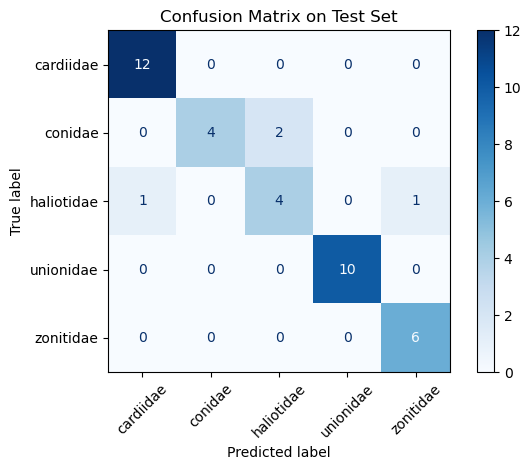

In [49]:
# ==== 1. Set model path and image size based on what it was trained with ====
model_path = "models/mollusca_models/mobilenetv2_combo1.h5"
image_size = (224, 224)         # <- Set this to match the model's training size
batch_size = 1                  # Test one at a time, no shuffling

# ==== 2. Create test generator using same logic ====
_, _, test_generator = create_generators(image_size=image_size, batch_size=batch_size)

# ==== 3. Load the trained model ====
model = load_model(model_path)
print(f"Loaded model from {model_path}")

# ==== 4. Evaluate on test set ====
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {acc:.4f}")

# ==== 5. Generate predictions ====
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# ==== 6. Get class labels in correct order ====
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

# ==== 7. Classification report ====
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ==== 8. Confusion matrix ====
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

🔍 Found 4 misclassified images.


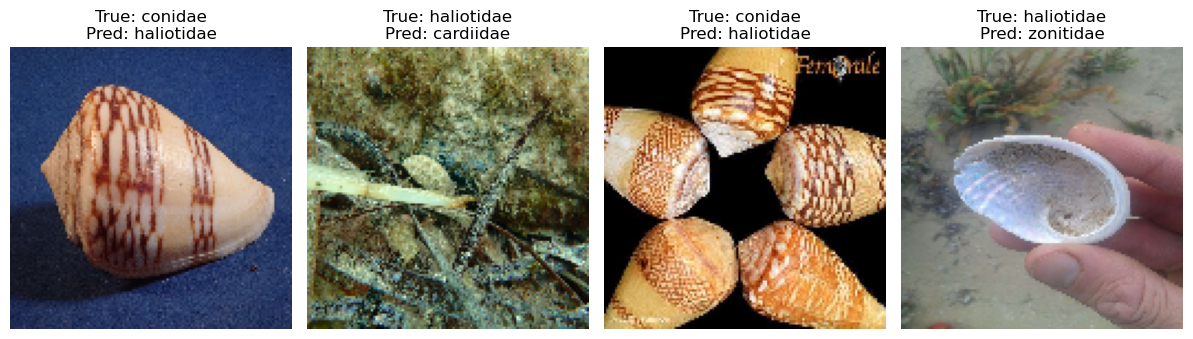

In [50]:
# 1. Get predictions
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 2. Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"🔍 Found {len(misclassified_indices)} misclassified images.")

# 3. Plot a few misclassified images
num_to_plot = min(10, len(misclassified_indices))  # Limit to 10 for visualization

plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_to_plot]):
    img_path = mollusca_test.iloc[idx]['filepath']
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize for display

    plt.subplot(2, 5, i+1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

plt.tight_layout()
plt.show()

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Loaded model from models/mollusca_models/mobilenetv2_combo85.h5
40/40 [==============================] - 4s 60ms/step - loss: 0.5297 - accuracy: 0.8250

 Test Accuracy: 0.8250
40/40 [==============================] - 5s 94ms/step

Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.85      0.92      0.88        12
     conidae       1.00      0.83      0.91         6
  haliotidae       0.67      0.67      0.67         6
   unionidae       0.82      0.90      0.86        10
   zonitidae       0.80      0.67      0.73         6

    accuracy                           0.82        40
   macro avg       0.83      0.80      0.81        40
weighted avg       0.83      0.82      0.82        40



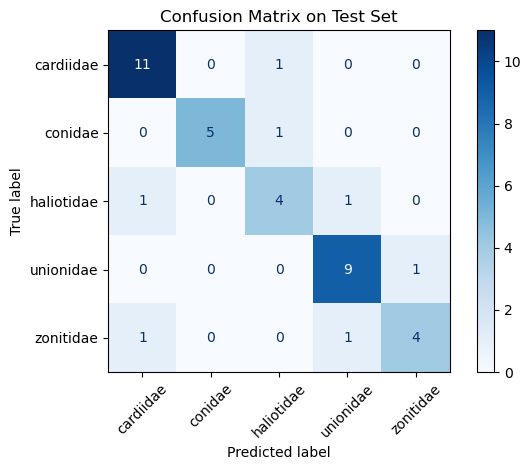

In [51]:
# ==== 1. Set model path and image size based on what it was trained with ====
model_path = "models/mollusca_models/mobilenetv2_combo85.h5"
image_size = (224, 224)         # <- Set this to match the model's training size
batch_size = 1                  # Test one at a time, no shuffling

# ==== 2. Create test generator using same logic ====
_, _, test_generator = create_generators(image_size=image_size, batch_size=batch_size)

# ==== 3. Load the trained model ====
model = load_model(model_path)
print(f"Loaded model from {model_path}")

# ==== 4. Evaluate on test set ====
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {acc:.4f}")

# ==== 5. Generate predictions ====
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# ==== 6. Get class labels in correct order ====
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

# ==== 7. Classification report ====
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ==== 8. Confusion matrix ====
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

🔍 Found 7 misclassified images.


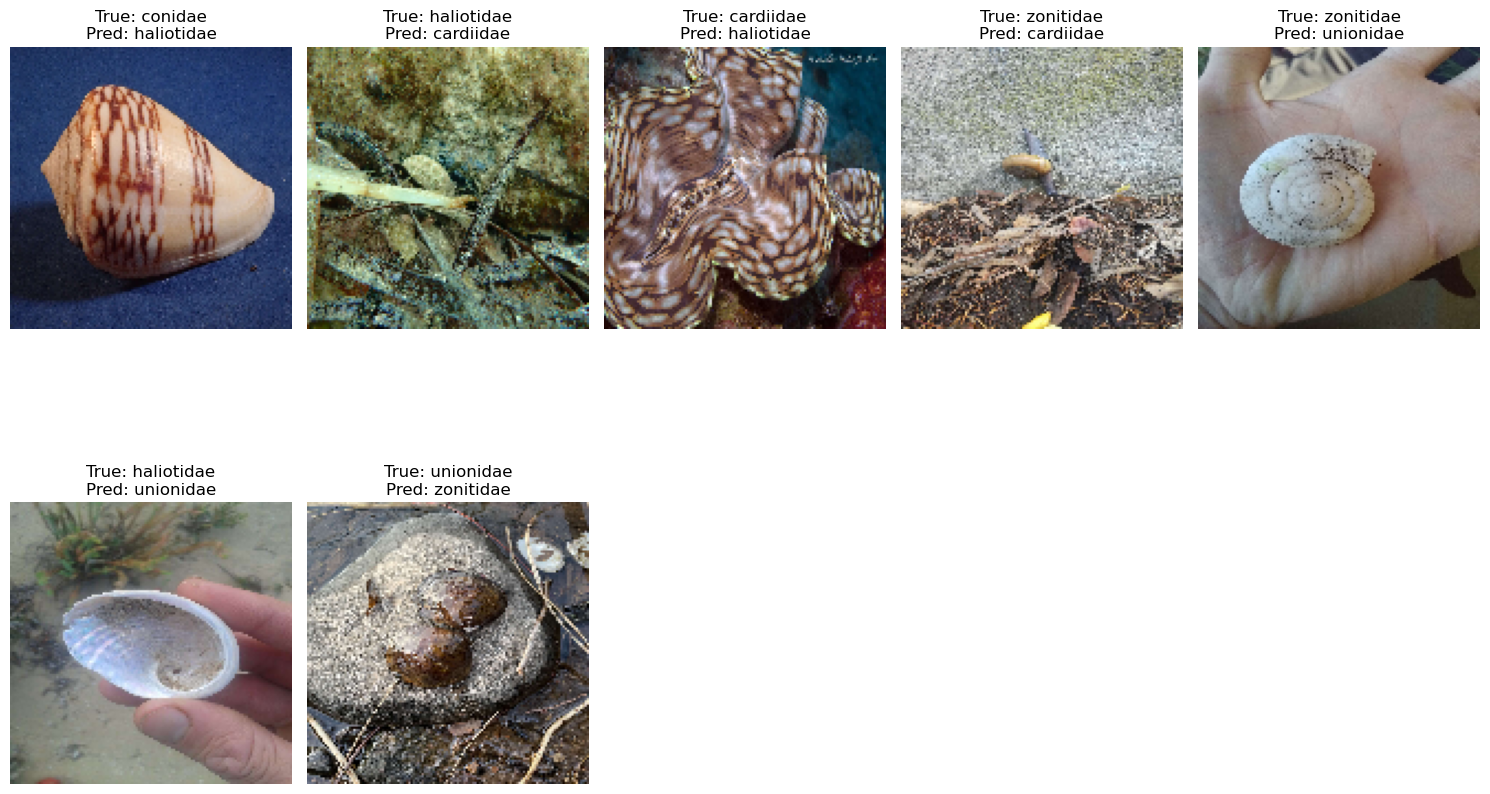

In [52]:
# 1. Get predictions
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 2. Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"🔍 Found {len(misclassified_indices)} misclassified images.")

# 3. Plot a few misclassified images
num_to_plot = min(10, len(misclassified_indices))  # Limit to 10 for visualization

plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_to_plot]):
    img_path = mollusca_test.iloc[idx]['filepath']
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize for display

    plt.subplot(2, 5, i+1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

plt.tight_layout()
plt.show()

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Loaded model from models/mollusca_models/mobilenetv2_combo99.h5
40/40 [==============================] - 4s 89ms/step - loss: 0.3131 - accuracy: 0.9500

 Test Accuracy: 0.9500
40/40 [==============================] - 5s 80ms/step

Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.92      1.00      0.96        12
     conidae       1.00      0.83      0.91         6
  haliotidae       0.83      0.83      0.83         6
   unionidae       1.00      1.00      1.00        10
   zonitidae       1.00      1.00      1.00         6

    accuracy                           0.95        40
   macro avg       0.95      0.93      0.94        40
weighted avg       0.95      0.95      0.95        40



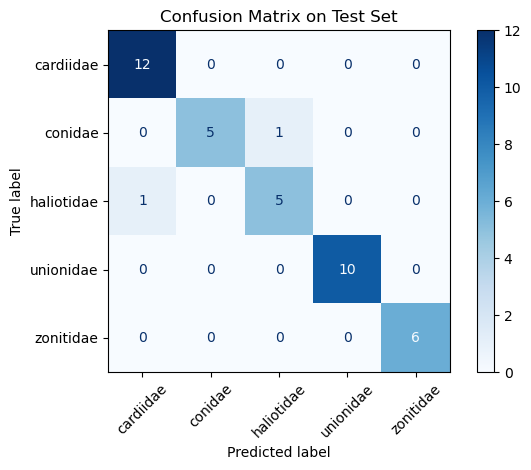

In [53]:
# ==== 1. Set model path and image size based on what it was trained with ====
model_path = "models/mollusca_models/mobilenetv2_combo99.h5"
image_size = (224, 224)         # <- Set this to match the model's training size
batch_size = 1                  # Test one at a time, no shuffling

# ==== 2. Create test generator using same logic ====
_, _, test_generator = create_generators(image_size=image_size, batch_size=batch_size)

# ==== 3. Load the trained model ====
model = load_model(model_path)
print(f"Loaded model from {model_path}")

# ==== 4. Evaluate on test set ====
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {acc:.4f}")

# ==== 5. Generate predictions ====
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# ==== 6. Get class labels in correct order ====
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

# ==== 7. Classification report ====
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# ==== 8. Confusion matrix ====
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

🔍 Found 2 misclassified images.


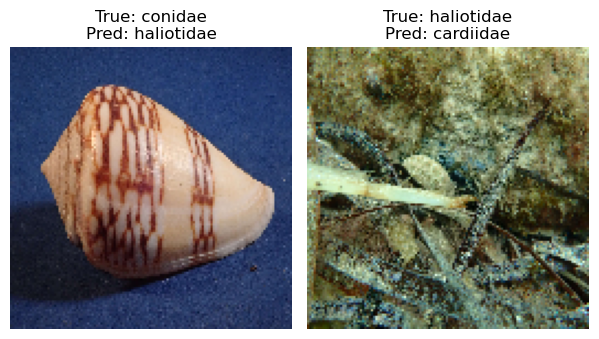

In [54]:
# 1. Get predictions
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 2. Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"🔍 Found {len(misclassified_indices)} misclassified images.")

# 3. Plot a few misclassified images
num_to_plot = min(10, len(misclassified_indices))  # Limit to 10 for visualization

plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_to_plot]):
    img_path = mollusca_test.iloc[idx]['filepath']
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize for display

    plt.subplot(2, 5, i+1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

plt.tight_layout()
plt.show()